In [349]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import random

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

import matplotlib as mpl
mpl.rc('font', family="Times New Roman")
mpl.rcParams['figure.dpi']=600
mpl.rcParams['savefig.dpi']=600
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['savefig.facecolor']='white'
mpl.rcParams['figure.facecolor']='white'
mpl.rcParams['lines.linewidth'] = 0.5

layer_size = 5

# ---------------------------------------------------------------------
def to_range (value, min_x, max_x):
    if value < min_x:
        return min_x
    elif value > max_x:
        return max_x
    else:
        return value
# ---------------------------------------------------------------------

Time, Load, Voltage, Power = np.loadtxt('out.csv', delimiter=',', skiprows=2, unpack=True)

# ----------------------------------------------------------------------------------------------------

class plotter_3D ():
    ID = 1
    def __init__ (self, X, Y, Z, X_label, Y_label, Z_label):
        self.fig = plt.figure (plotter_3D.ID, figsize=plt.figaspect(9/16))
        plotter_3D.ID += 1
        
        ax = self.fig.gca(projection='3d')
        ax.set_xlabel(X_label)
        ax.set_ylabel(Y_label)
        ax.set_zlabel(Z_label)
                 
        xi = np.linspace(min(X),max(X),100)
        yi = np.linspace(min(Y),max(Y),100)
        zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')
        xig, yig = np.meshgrid(xi, yi)
        
        surf = ax.plot_surface(xig, yig, zi, linewidth=0)
        
        ax.set_xlim3d(0, max(X))
        ax.set_ylim3d(0, max(Y))
        ax.set_zlim3d(0, round(max(Z)))
        
        plt.show()

# ----------------------------------------------------------------------------------------------------        
        
class MP():
    def __init__ (self, data):
        self.label = "Theoretical maximum"
        self.track = []
        self.total_power = 0
        self.max_power_line(data)
        
    def max_power_line (self, data):
        self.track = []
        for i in data:
            powers = [a[-1] for a in i]
            power_max = max(powers)
            self.total_power += power_max
            index = powers.index(power_max)
            self.track.append (i[index].tolist())

# ----------------------------------------------------------------------------------------------------            
            
class DO_container ():
    def __init__ (self, data, step = 1, init_index = None):
        self.data = data
        self.step = step
        self.label = "Disturbe & observe (step = " +  str(step) + ")"
        self.track = []
        self.random_start = (init_index == None)
        self.start = init_index
        self.total_power = 0        
        self.analyze()
    
    def analyze (self):
        if self.random_start:
            # conversion to list is required because data[i] is np.ndarray, 
            # that doesn't have opportunity to find index of element
            self.start = self.data[0].tolist().index(random.choice(self.data[0].tolist()))        
        # if we want to analyze the same dataset several times with different startpoint
        # we are deleting results of previous anlysis
        self.track = []        
        # index for tracking records in timeline        
        index = self.start
        for timestamp in self.data[:]:
            point = timestamp [index].tolist()
            self.track.append(point)
            U = point[-2]
            P = point [-1]
            self.total_power += P
            # if it is not a beginning
            if 'Pprev' in locals():                
                deltaP = round(P - Pprev, 3)
                deltaU = round(U - Uprev)
                index_step = self.define_step(deltaU, deltaP)            
            # if it is the beginning only
            else:                                
                index_step = random.choice([-1, 1])*self.step            
            Uprev = U
            Pprev = P            
            index += index_step            
            # check of violation range limits
            if index < 0:
                index = 0
            elif index >= len (timestamp):
                index = len(timestamp) - 1
    
    def define_step (self, dU, dP):
        if dP >= 0:
            if dU >= 0:
                return self.step                
            else:                    
                return -self.step                
        else:
            if dU < 0:
                return -self.step                
            else:
                return self.step

# ----------------------------------------------------------------------------------------------------                        

# FNN - Following Neural Network

class FNN ():
    def __init__ (self, data, epochs = 10):
        self.data = data
        self.epochs = epochs
        self.label = "FNN with "+ str(self.epochs) +" epochs"        
        # ----------------------------------------------------------
        self.line = []
        self.track = []
        self.total_power = 0
        loads = data[:,1]
        self.load_max = max(loads)
        self.load_min = min(loads)
        # ----------------------------------------------------------
        self.mpl()
        self.transform_data()
        
        # Model description
        self.model = Sequential()
        self.model.add(Dense(layer_size, input_dim=3, activation='relu'))
        self.model.add(Dense(layer_size, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
        
    def mpl(self):
        self.line = []
        # get all times:
        Times = self.data[:, 0]
        # splitting input dataset by unique values in time
        sorted_data = [self.data[self.data[:,0]==i, :] for i in np.unique(Times)]
        # at every timestep - find point with maximul power generation
        for timestamp in sorted_data:
            # collect all powers at every load
            powers = [point[-1] for point in timestamp]
            # find the maximum
            max_power = max(powers)
            # find the location of maximum power
            index = powers.index(max_power)
            self.line.append (timestamp[index].tolist())
    
    def transform_data (self):
        
        # data to train the NN
        self.train_x = []
        self.train_y = []
        self.powers = []
        self.best_powers = []
        
        for real_point in self.data:
            real_point = real_point.tolist()
            time_check = real_point[0]
            #print (real_point, time_check)
            for best_point in self.line:    
                time_reference = best_point[0]
                #print (best_point, time_reference)
                if time_reference == time_check:
                    # coppying time, load, voltage to train_x
                    self.train_x.append(real_point[:3])
                    # coppying the best load at current step to train_y
                    self.train_y.append (best_point[1])
                    # coppying the power generated                    
                    self.powers.append(real_point[-1])
                    self.best_powers.append(best_point[-1])
                    
        #for i in zip(self.train_x, self.train_y, self.powers, self.best_powers):
        #    print (i)
        
    def fit (self):
        self.model.fit(self.train_x, self.train_y, epochs=self.epochs, batch_size=50)
        
    def predict(self, x):
        
        predictions = []        
        loads = [point[1] for point in self.data]
        
        max_load = max (loads)
        min_load = min (loads)
        
        raw_predictions = self.model.predict(x)
       
        for i in raw_predictions:
            prediction = [round(to_range(i[0], min_load, max_load))]
            predictions.append(prediction)
        
        predictions = np.array(predictions)
        
        #for i in np.column_stack((self.train_x, self.powers, self.train_y, raw_predictions, predictions)):
        #    print (i.tolist())
        return predictions
    
    def predict_and_track (self):
        
        self.track = []
        self.total_power = 0
        
        # biuld predictions for each testing point
        predictions = self.predict(self.data[:, 0:3])
        # create the sorting dataset
        raw_data = np.column_stack ((self.data[:, 0:3], predictions, self.data[:,3]))
        # sort dataset by time_poins
        sorted_data = [raw_data[raw_data[:,0]==i, :] for i in np.unique(raw_data[:, 0])]
        
        # pick random point for beginning
        load = random.randrange(self.load_min, self.load_max, 1)
        # runnin though all time points
        for time_stamp in sorted_data:
            # print (load)
            # runnin though all available loads
            for point in time_stamp:
                # if load is correspont to predicted as optimal:
                if point[1] == load:
                    # copy point to MPP track
                    self.track.append(point)
                    # add achived power to total counter
                    self.total_power += point[4]
                    # rewrite the load value for next step
                    load = point[3]
                    # run away from inner for loop
                    break            
# ----------------------------------------------------------------------------------------------------            

# PNN - Predicting Neural Network

class PNN ():
    def __init__ (self, data, epochs = 10):
        self.data = data
        self.epochs = epochs
        self.label = "PNN with "+ str(self.epochs) +" epochs"        
        # ----------------------------------------------------------
        self.line = []
        self.track = []
        self.total_power = 0
        loads = data[:,1]
        self.load_max = max(loads)
        self.load_min = min(loads)
        # ----------------------------------------------------------
        self.mpl()
        self.transform_data()
        
        # Model description
        self.model = Sequential()
        self.model.add(Dense(layer_size, input_dim=3, activation='relu'))
        self.model.add(Dense(layer_size, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
        
    def mpl(self):
        self.line = []
        # get all times:
        Times = self.data[:, 0]
        # splitting input dataset by unique values in time
        sorted_data = [self.data[self.data[:,0]==i, :] for i in np.unique(Times)]
        # at every timestep - find point with maximul power generation
        for timestamp in sorted_data:
            # collect all powers at every load
            powers = [point[-1] for point in timestamp]
            # find the maximum
            max_power = max(powers)
            # find the location of maximum power
            index = powers.index(max_power)
            self.line.append (timestamp[index].tolist())
    
    def transform_data (self):
        
        # data to train the NN
        self.train_x = []
        self.train_y = []
        self.powers = []
        self.best_powers = []
        
        for real_point in self.data:
            real_point = real_point.tolist()
            time_check = real_point[0]
            #print (real_point, time_check)
            for best_point in self.line:    
                time_reference = best_point[0]
                #print (best_point, time_reference)
                if time_reference == (time_check-1):
                    # coppying time, load, voltage to train_x
                    self.train_x.append(real_point[:3])
                    # coppying the best load at current step to train_y
                    self.train_y.append (best_point[1])
                    # coppying the power generated                    
                    self.powers.append(real_point[-1])
                    self.best_powers.append(best_point[-1])
                    
        #for i in zip(self.train_x, self.train_y, self.powers, self.best_powers):
        #    print (i)
        
    def fit (self):
        self.model.fit(self.train_x, self.train_y, epochs=self.epochs, batch_size=50)
        
    def predict(self, x):
        
        predictions = []        
        loads = [point[1] for point in self.data]
        
        max_load = max (loads)
        min_load = min (loads)
        
        raw_predictions = self.model.predict(x)
       
        for i in raw_predictions:
            prediction = [round(to_range(i[0], min_load, max_load))]
            predictions.append(prediction)
        
        predictions = np.array(predictions)
        
        #for i in np.column_stack((self.train_x, self.powers, self.train_y, raw_predictions, predictions)):
        #    print (i.tolist())
        return predictions
    
    def predict_and_track (self):
        
        self.track = []
        self.total_power = 0
        
        # biuld predictions for each testing point
        predictions = self.predict(self.data[:, 0:3])
        # create the sorting dataset
        raw_data = np.column_stack ((self.data[:, 0:3], predictions, self.data[:,3]))
        # sort dataset by time_poins
        sorted_data = [raw_data[raw_data[:,0]==i, :] for i in np.unique(raw_data[:, 0])]
        
        # pick random point for beginning
        load = random.randrange(self.load_min, self.load_max, 1)
        # runnin though all time points
        for time_stamp in sorted_data:
            #print (load)
            # runnin though all available loads
            for point in time_stamp:
                # if load is correspont to predicted as optimal:
                if point[1] == load:
                    # copy point to MPP track
                    self.track.append(point)
                    # add achived power to total counter
                    self.total_power += point[4]
                    # rewrite the load value for next step
                    load = point[3]
                    # run away from inner for loop
                    break


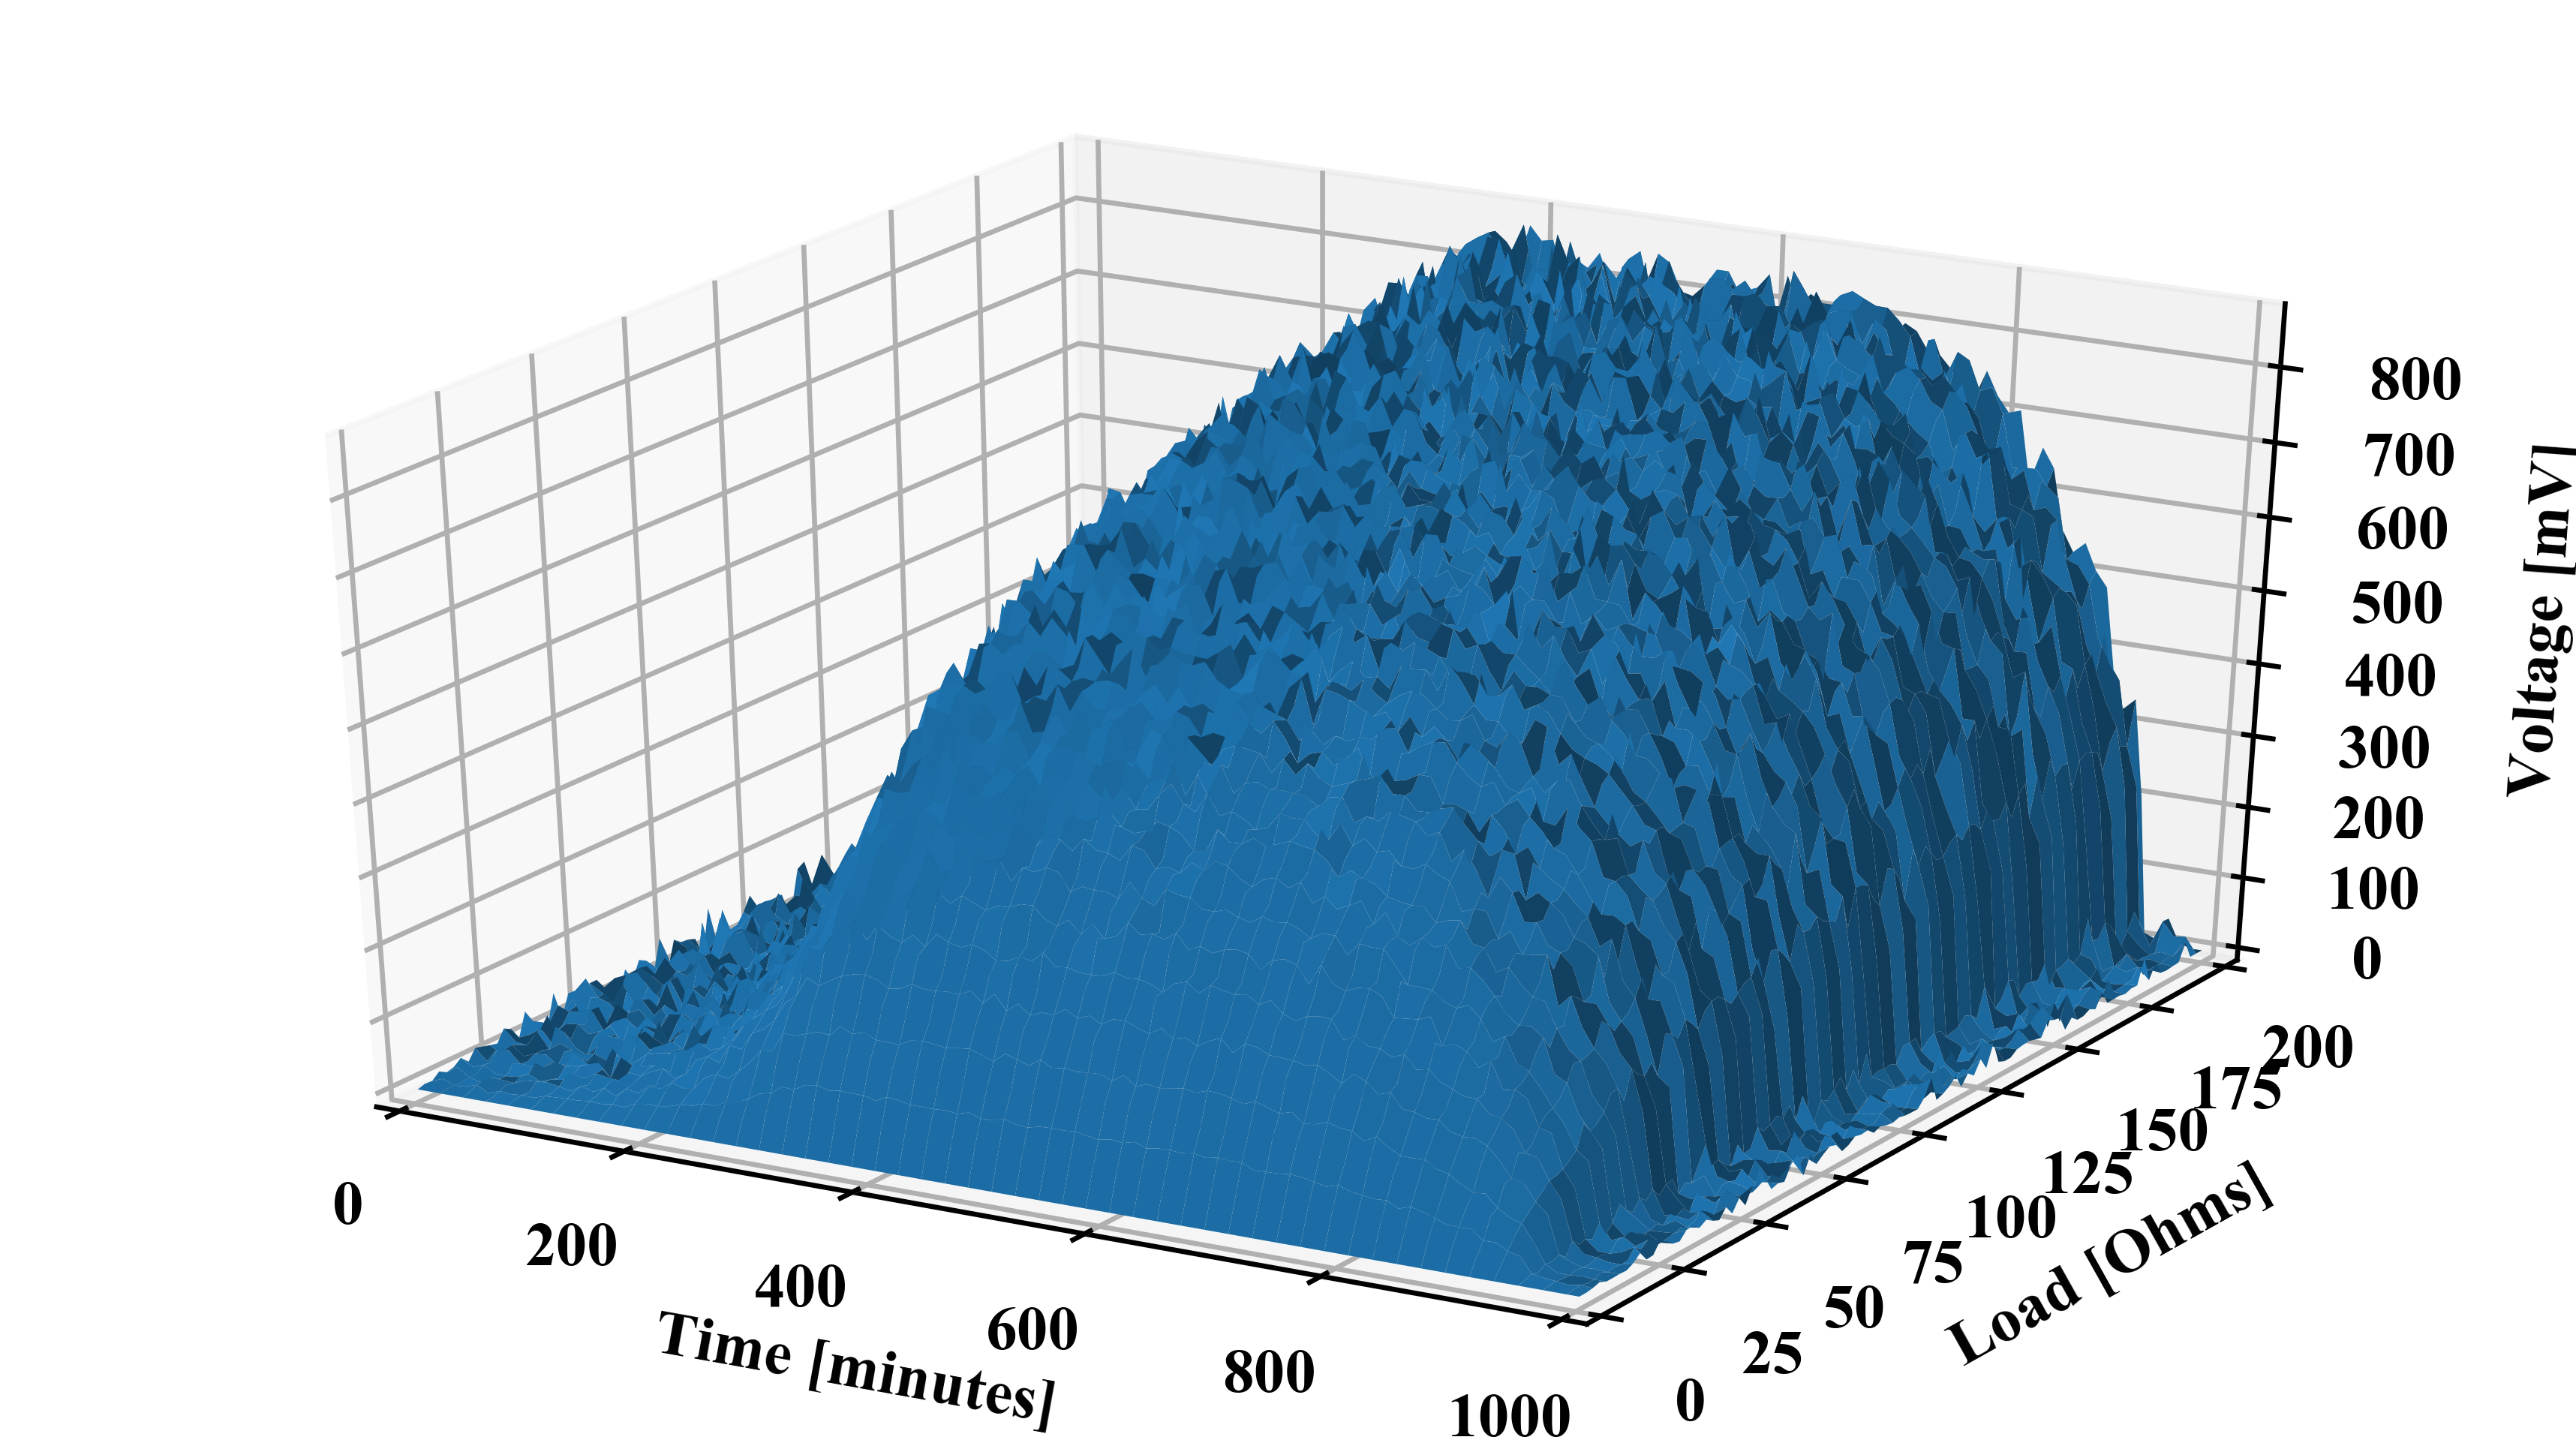

In [350]:
plot_1 = plotter_3D (Time, Load, Voltage, 'Time [minutes]', 'Load [Ohms]', 'Voltage [mV]')

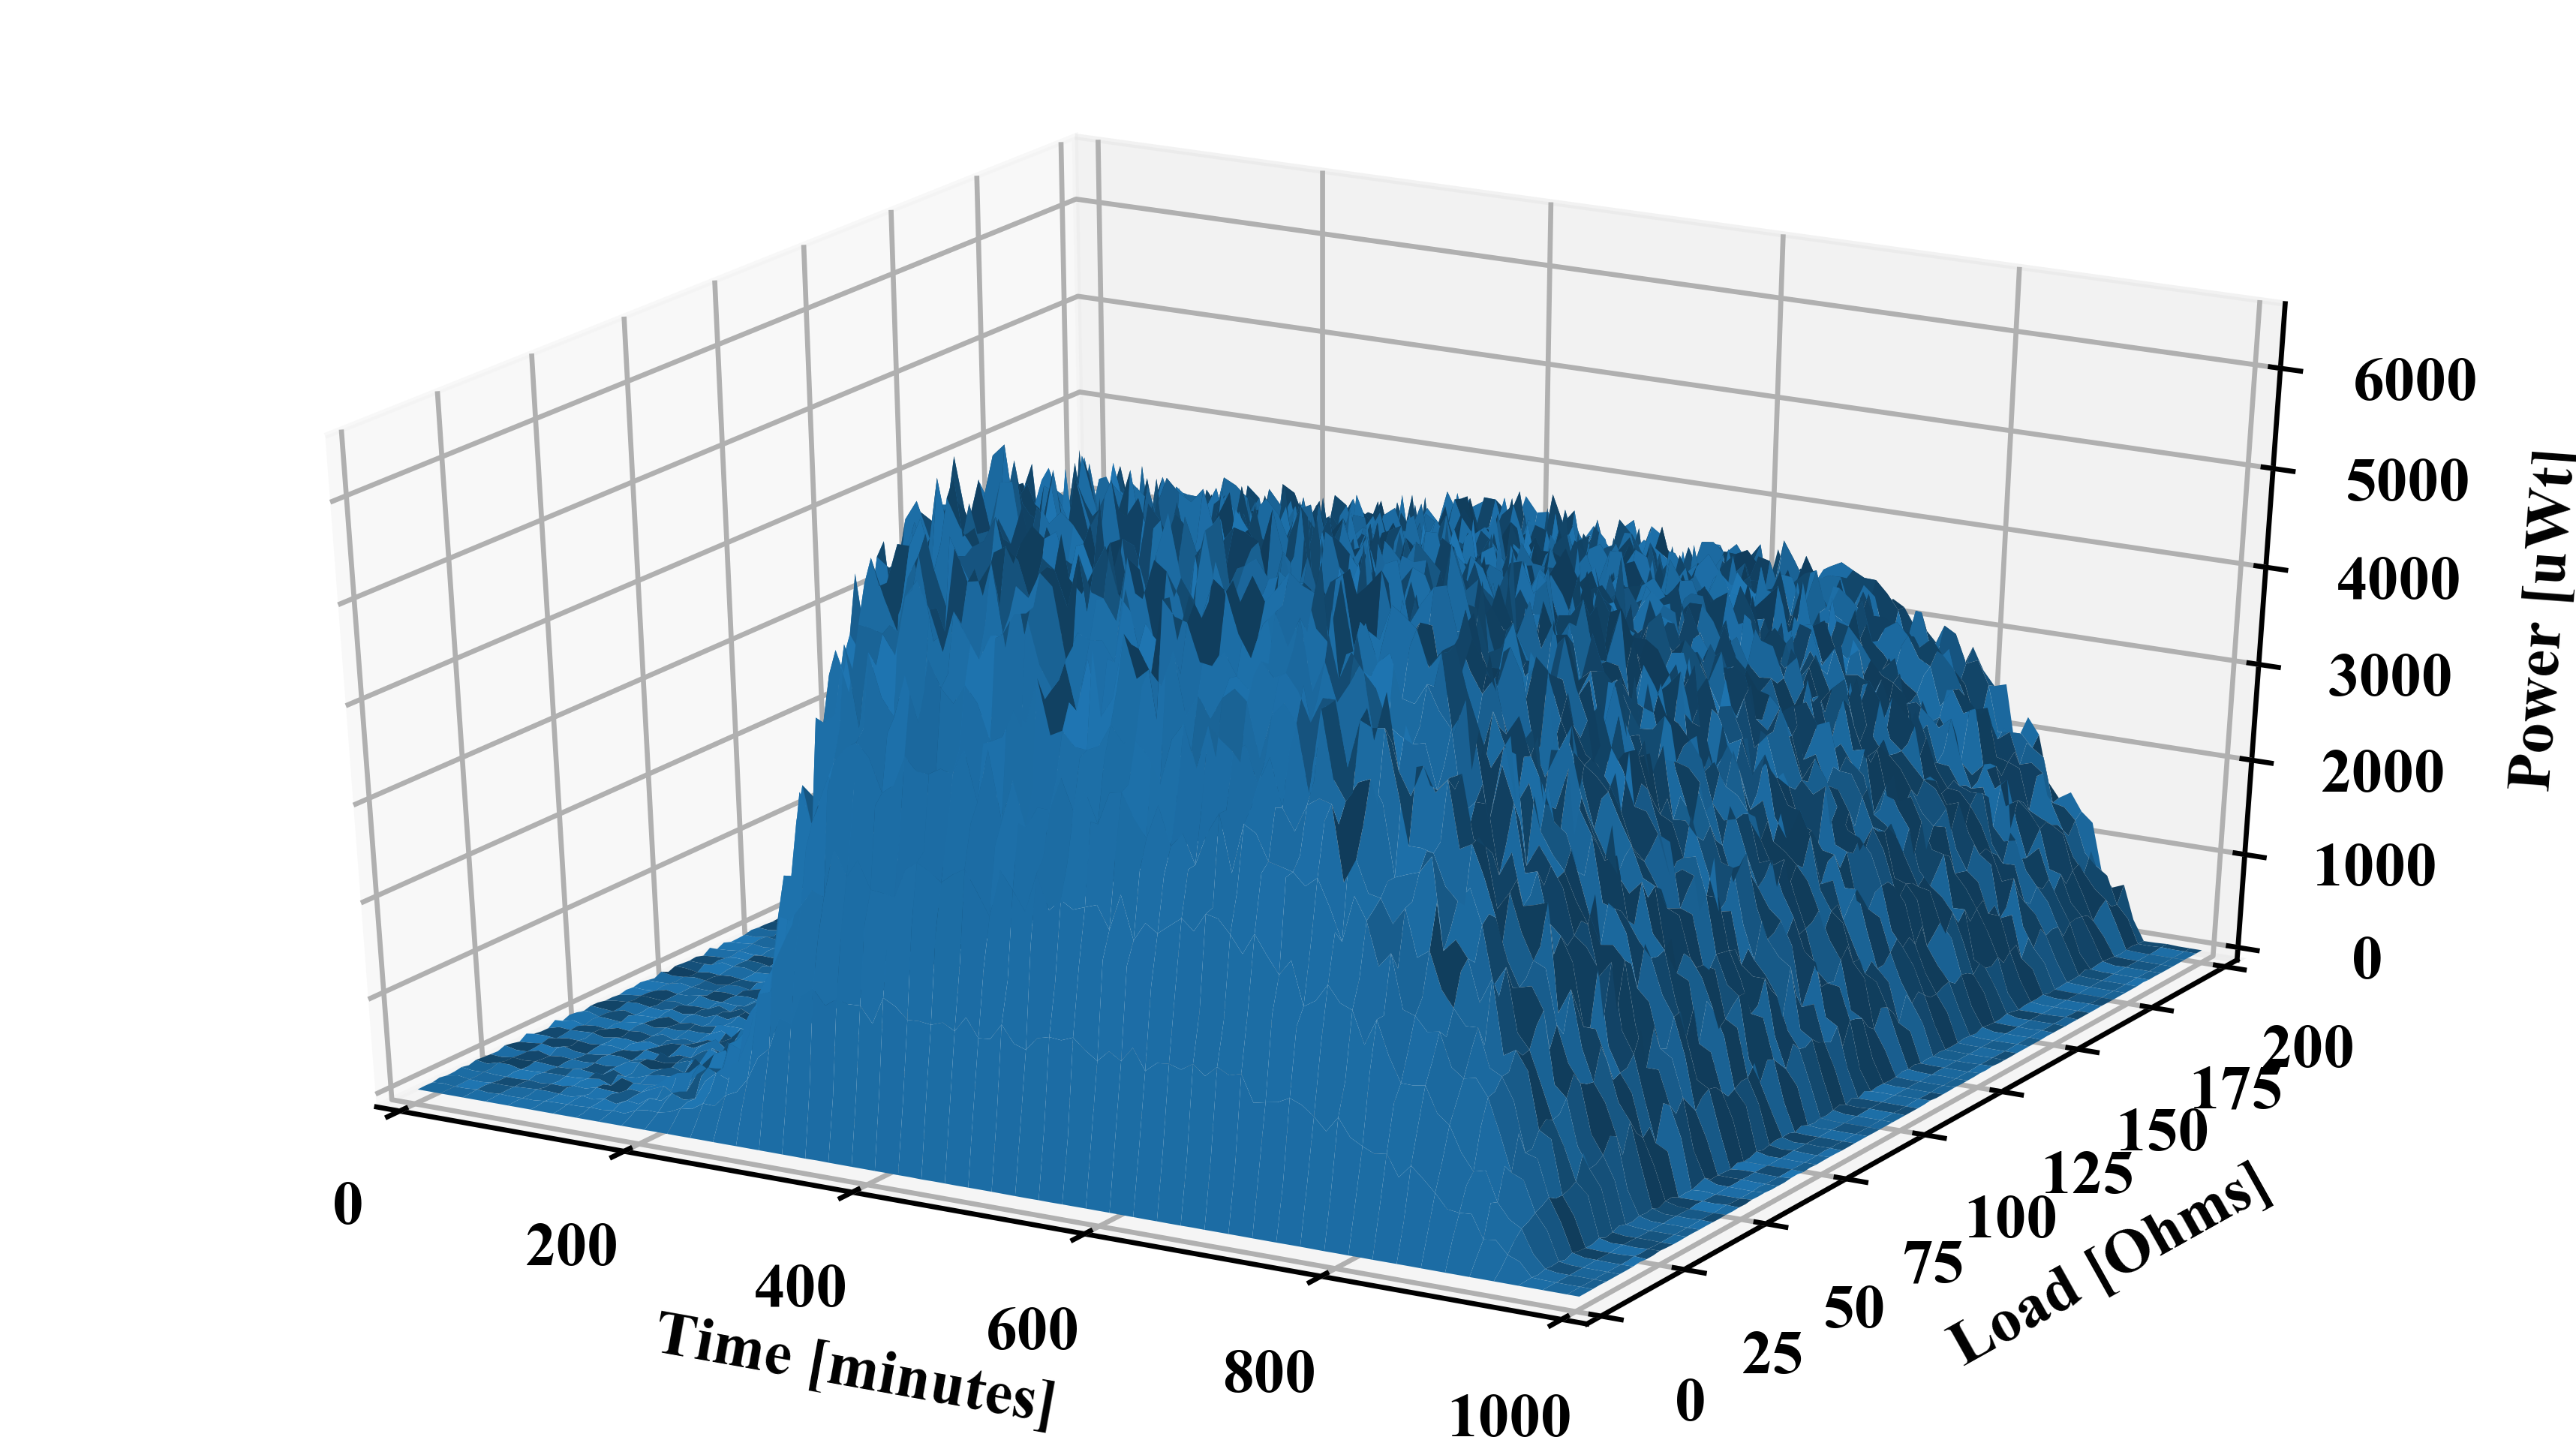

In [351]:
plot_2 = plotter_3D (Time, Load, Power, 'Time [minutes]', 'Load [Ohms]', 'Power [uWt]')

In [352]:
data = np.column_stack((Time, Load, Voltage, Power))

In [353]:
# Spliting / grouping into array based on timeline
data_1 = [ data[data[:,0]==i, :] for i in np.unique(Time)]

In [354]:
# MPL - Maximum Power Line
MPL = MP (data_1)
dataset = [MPL,]
#for i in MPL.track:
#    print (i)

In [355]:
DO_1 = DO_container (data_1, step = 1)
dataset.append(DO_1)
DO_2 = DO_container (data_1, step = 2)
dataset.append(DO_2)
DO_3 = DO_container (data_1, step = 3)
dataset.append(DO_3)
DO_4 = DO_container (data_1, step = 4)
dataset.append(DO_4)

In [356]:
def plot_power_differential (data_array):
    plot = mpl.pyplot
    plot.figure(0)
    plot.ylabel('Momentary power generation, [$\mu$W]')
    plot.xlabel('Lifetime, [minutes]')
    plot.grid(linestyle='--')
    
    x_max = 0
    y_max = 0
    
    for data in data_array:
        
        x = [datum[0] for datum in data.track]
        y = [datum[-1] for datum in data.track]
        #print (x)
        #print (y)

        plot.plot(x, y, label=data.label)
        
        x_max = max(x_max,max(x))
        y_max = max(y_max,max(y))
    
    plot.axis([0, x_max, 0, y_max + 100])
    plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 2)
    plot.title ("Differential curve of power production")
    plot.show()

In [357]:
def plot_power_integral (data_array):
    plot = mpl.pyplot
    plot.figure(1)
    plot.ylabel('Totaly generated power, [mW $\\times$ minute]')
    plot.xlabel('Lifetime, [minutes]')
    plot.grid(linestyle='--')
    x_max = 0
    y_max = 0
    for data in data_array:
        x = [datum[0] for datum in data.track]
        y = [datum[-1] for datum in data.track]
        for i in range(1, len(y)):
            y[i] += y[i-1]
        y = [i/1000 for i in y]
        plot.plot(x, y, label=data.label)
        x_max = max(x_max,max(x))
        y_max = max(y_max,max(y))
    
    plot.axis([0, x_max, 0, y_max + 100])  
    plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 2)
    plot.title ("Integral curve of power production")
    plot.show()

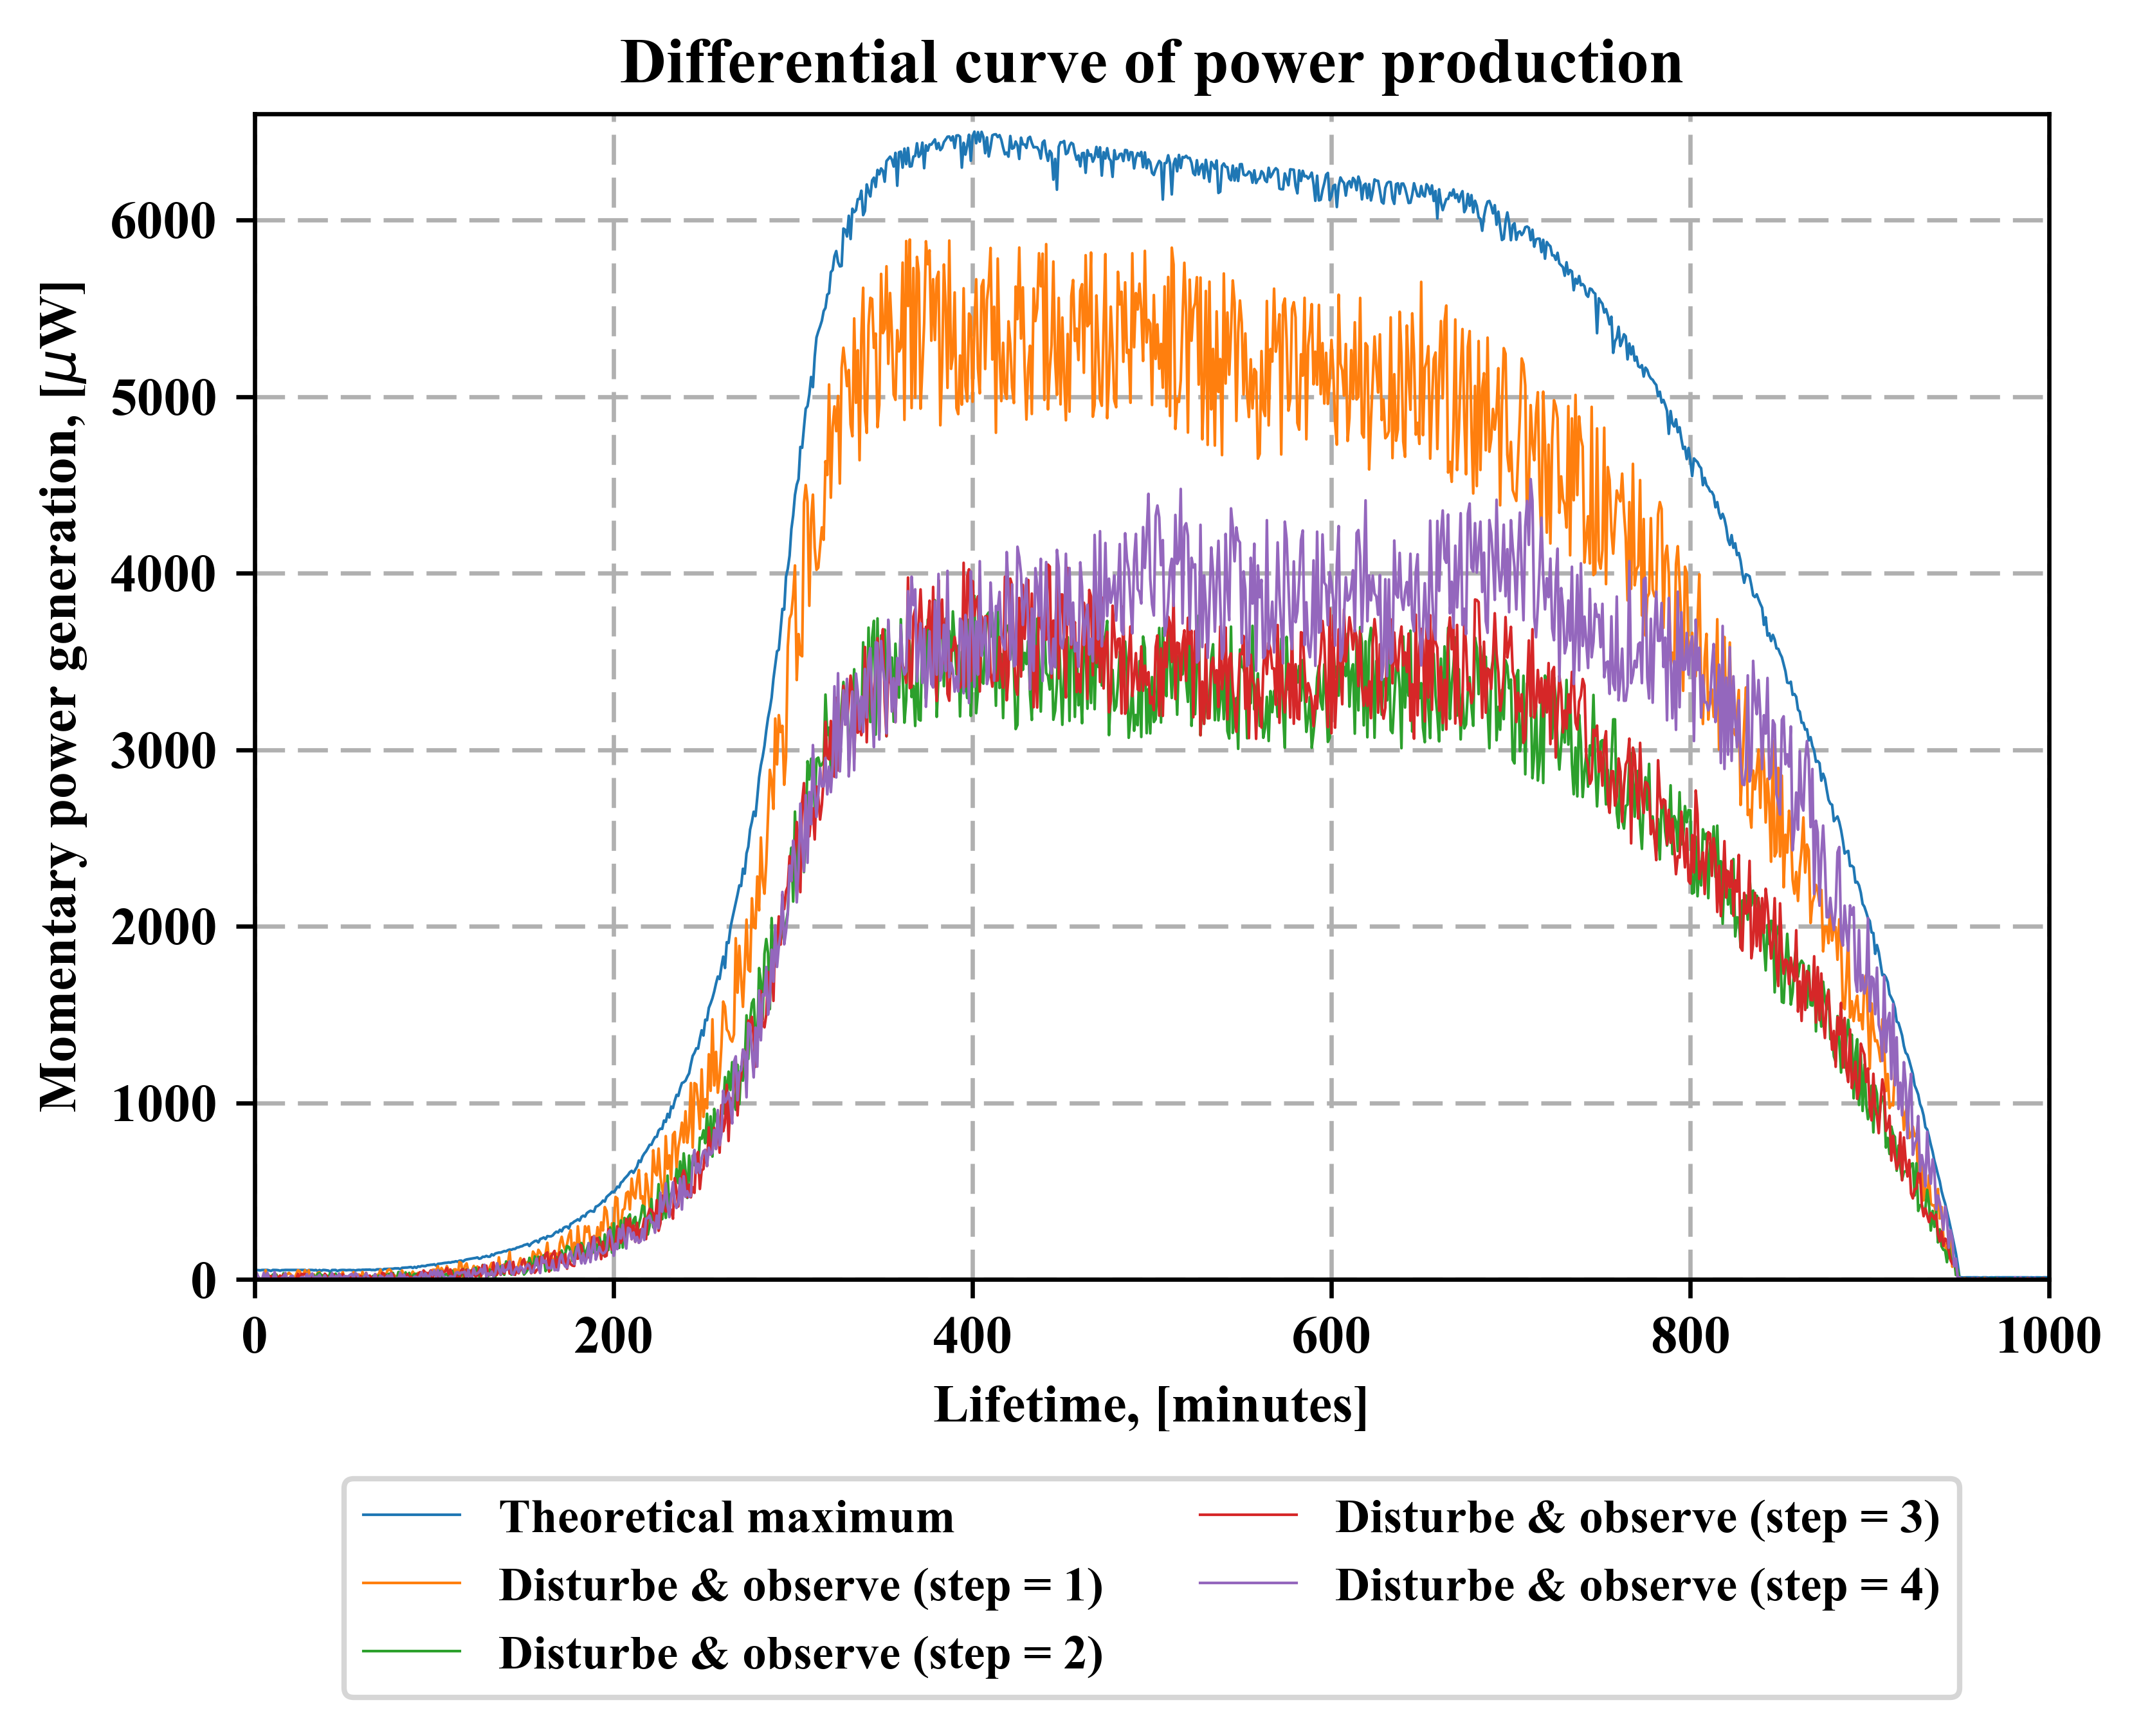

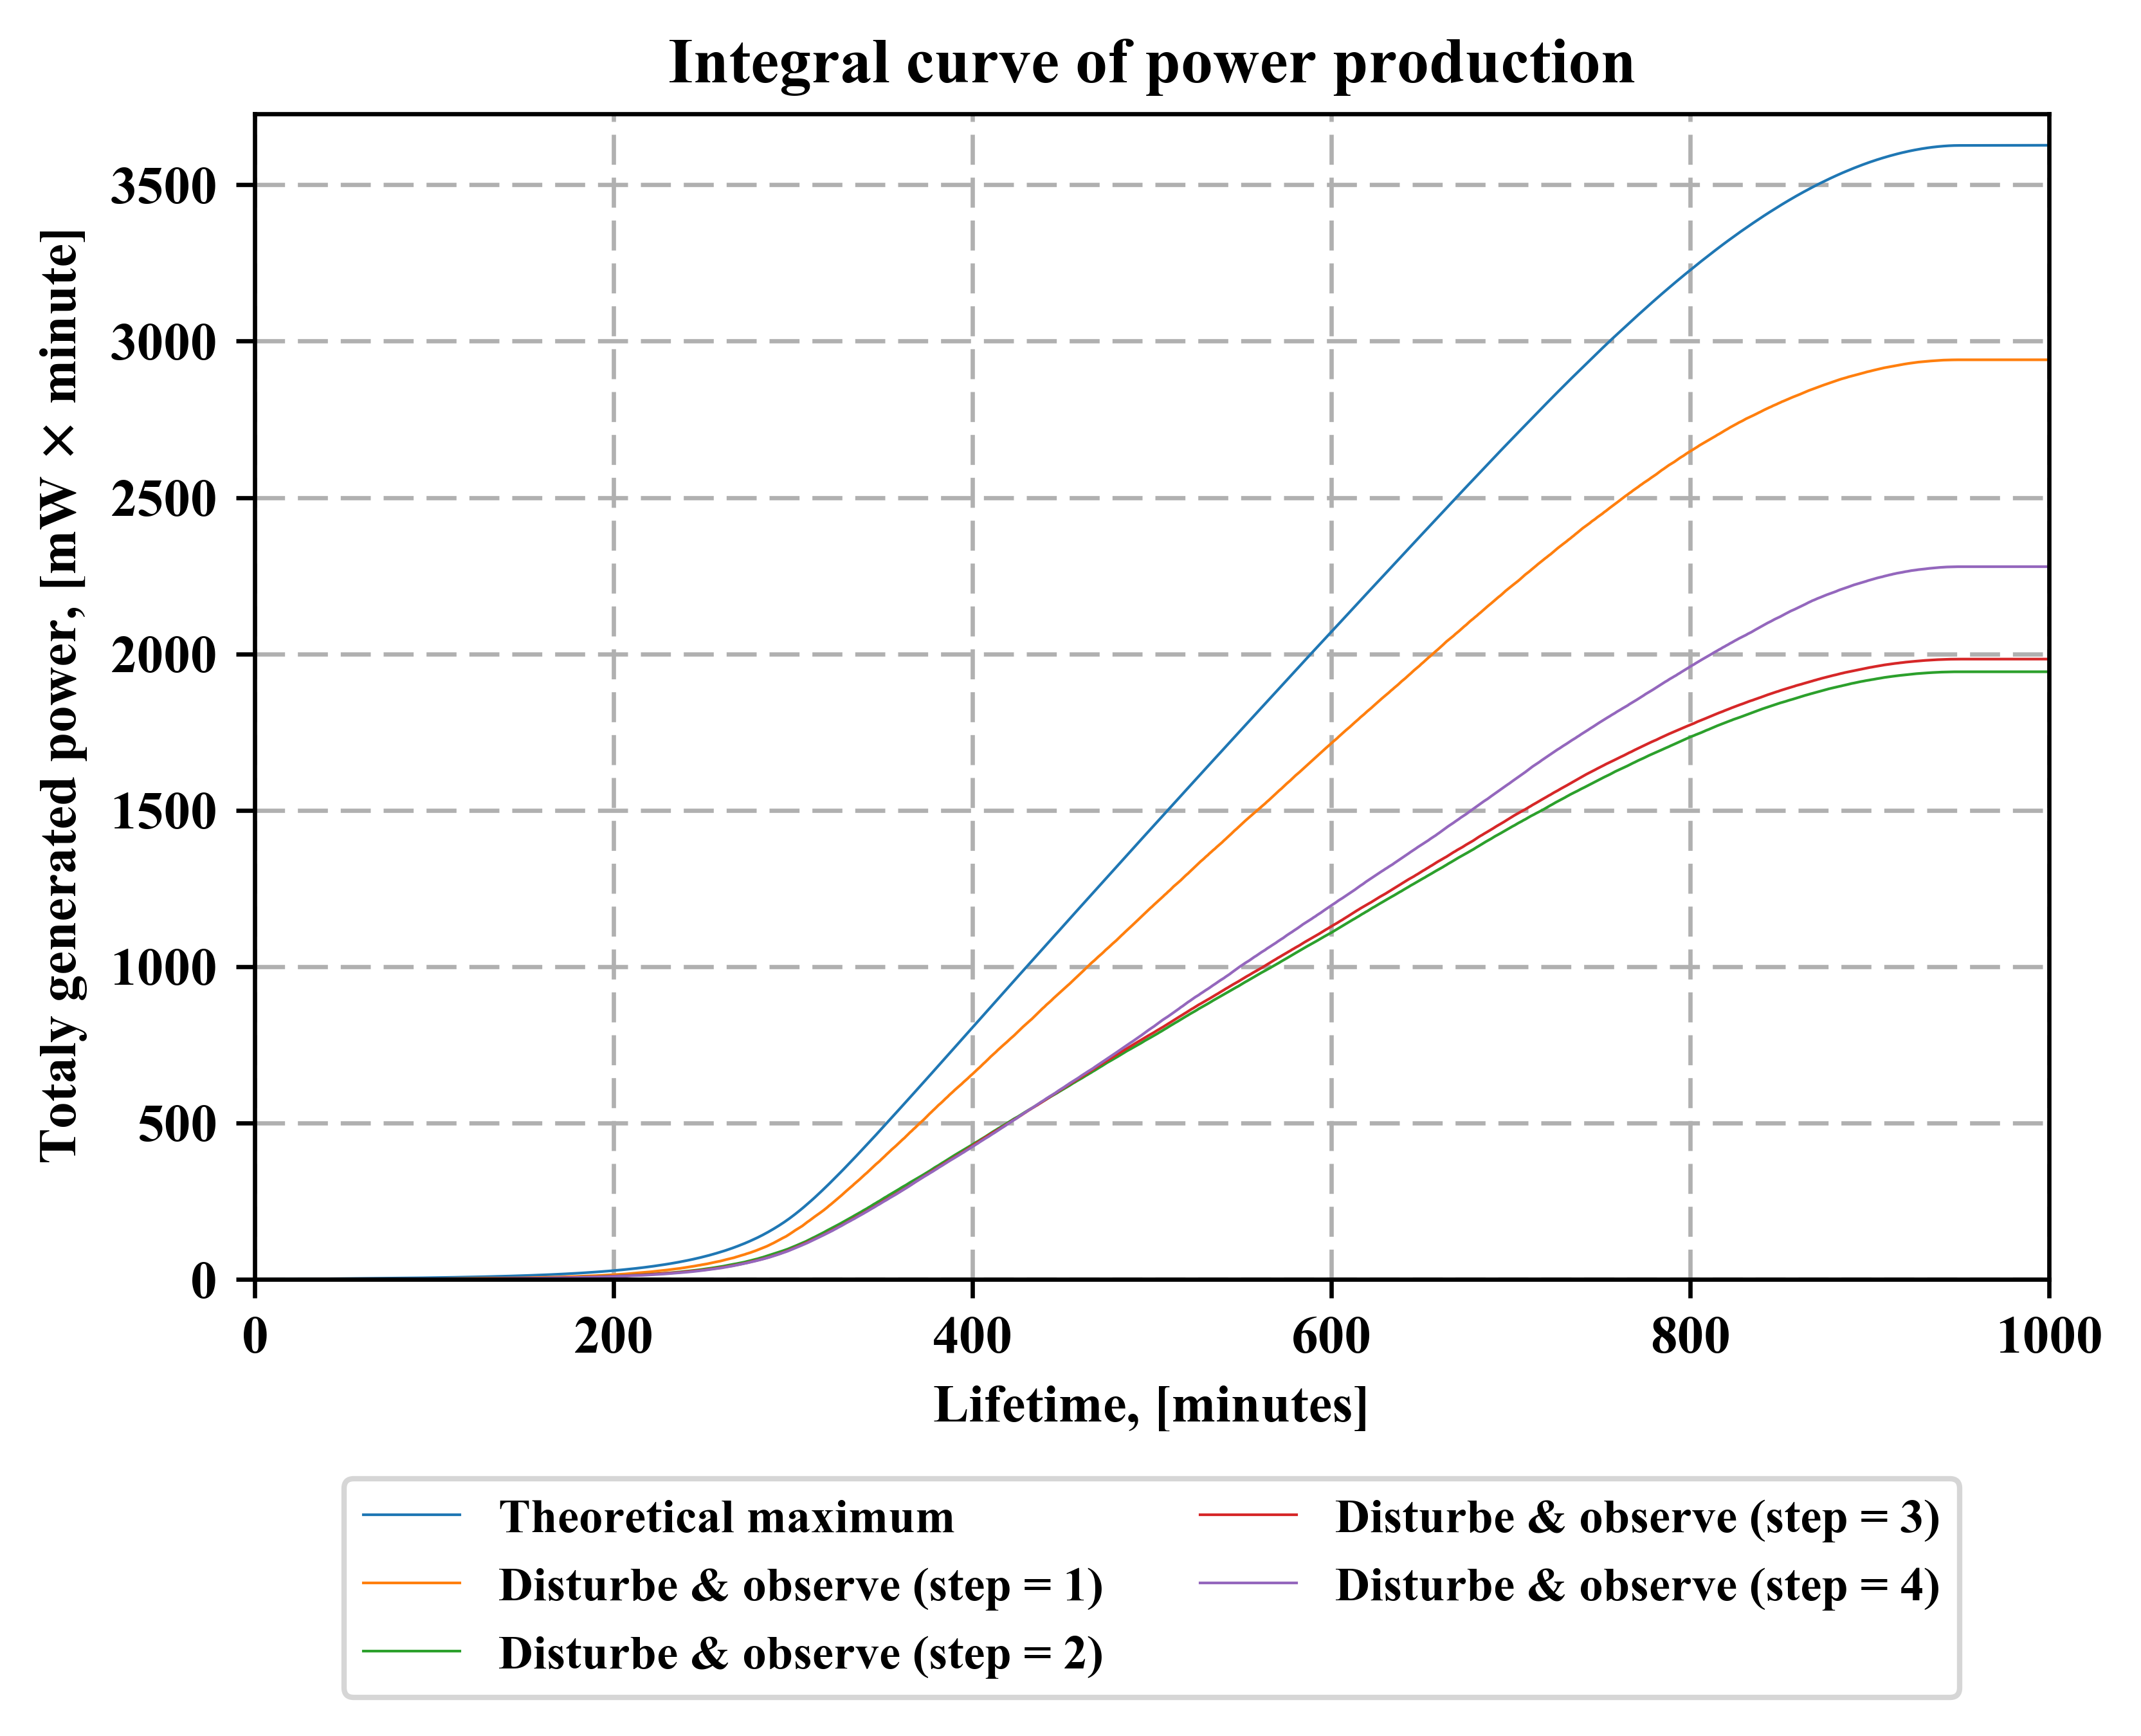

Theoretical maximum 	:  3626.249 mWt
	Loses 	: 0.0 %
Disturbe & observe (step = 1) 	:  2940.365 mWt
	Loses 	: 18.91 %
Disturbe & observe (step = 2) 	:  1942.913 mWt
	Loses 	: 46.42 %
Disturbe & observe (step = 3) 	:  1983.448 mWt
	Loses 	: 45.3 %
Disturbe & observe (step = 4) 	:  2278.93 mWt
	Loses 	: 37.15 %


In [358]:
plot_power_differential (dataset)
plot_power_integral (dataset)
for data in dataset:    
    print (data.label, "\t: ", round(data.total_power/1000, 3), "mWt")
    print ("\tLoses \t:", round((1 - data.total_power / dataset[0].total_power)*100, 2), "%")

In [359]:
NN_inputs = np.loadtxt('out.csv', delimiter=",", skiprows=2)

In [360]:
# Following Neural Network
dataset_2 = [MPL]
FNN_1 = FNN (NN_inputs, epochs = 1)
FNN_1.fit()
FNN_1.predict_and_track()
dataset_2.append(FNN_1)

FNN_2 = FNN (NN_inputs, epochs = 2)
FNN_2.fit()
FNN_2.predict_and_track()
dataset_2.append(FNN_2)

FNN_3 = FNN (NN_inputs, epochs = 3)
FNN_3.fit()
FNN_3.predict_and_track()
dataset_2.append(FNN_3)

Epoch 1/1
200200/200200 [==============================] - 10s - loss: 739.4060 - acc: 0.0360    
Epoch 1/2
200200/200200 [==============================] - 9s - loss: 1022.6190 - acc: 0.0322     
Epoch 2/2
200200/200200 [==============================] - 8s - loss: 85.7246 - acc: 0.0513     
Epoch 1/3
200200/200200 [==============================] - 9s - loss: 4963.7806 - acc: 0.0000e+00     
Epoch 2/3
200200/200200 [==============================] - 7s - loss: 1592.3591 - acc: 0.0000e+00     
Epoch 3/3
200200/200200 [==============================] - 7s - loss: 1295.2366 - acc: 0.0000e+00     


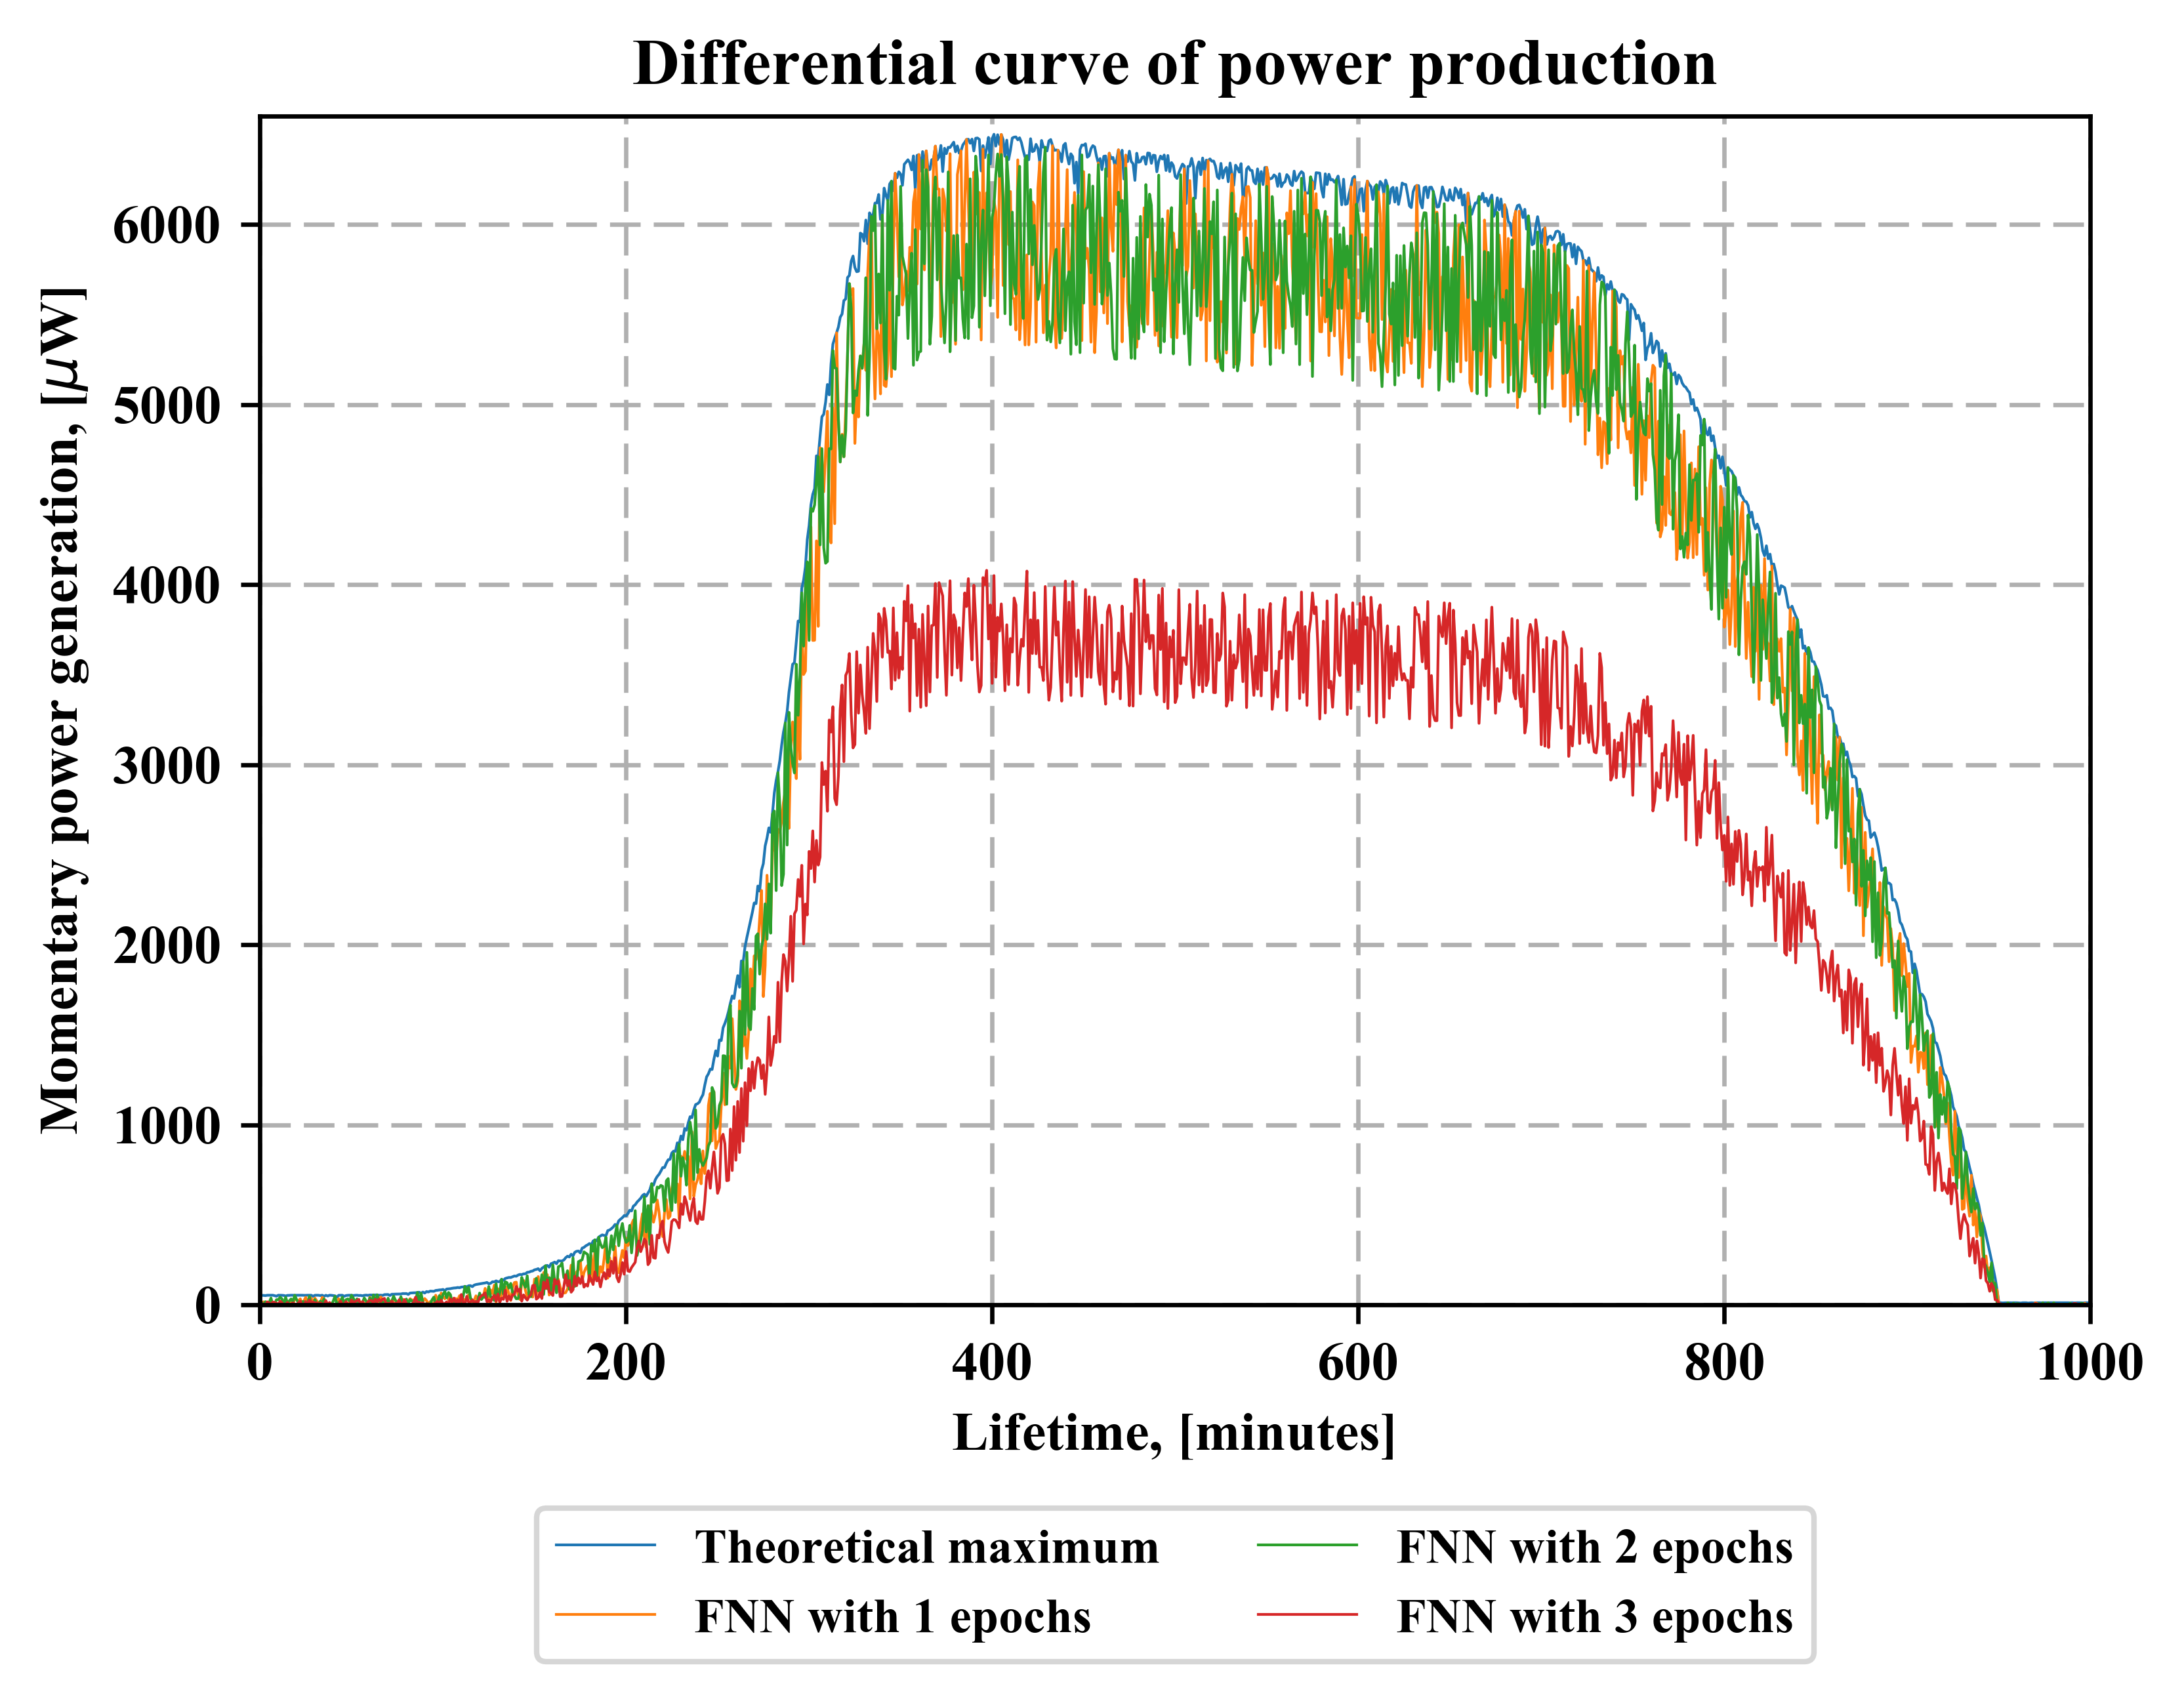

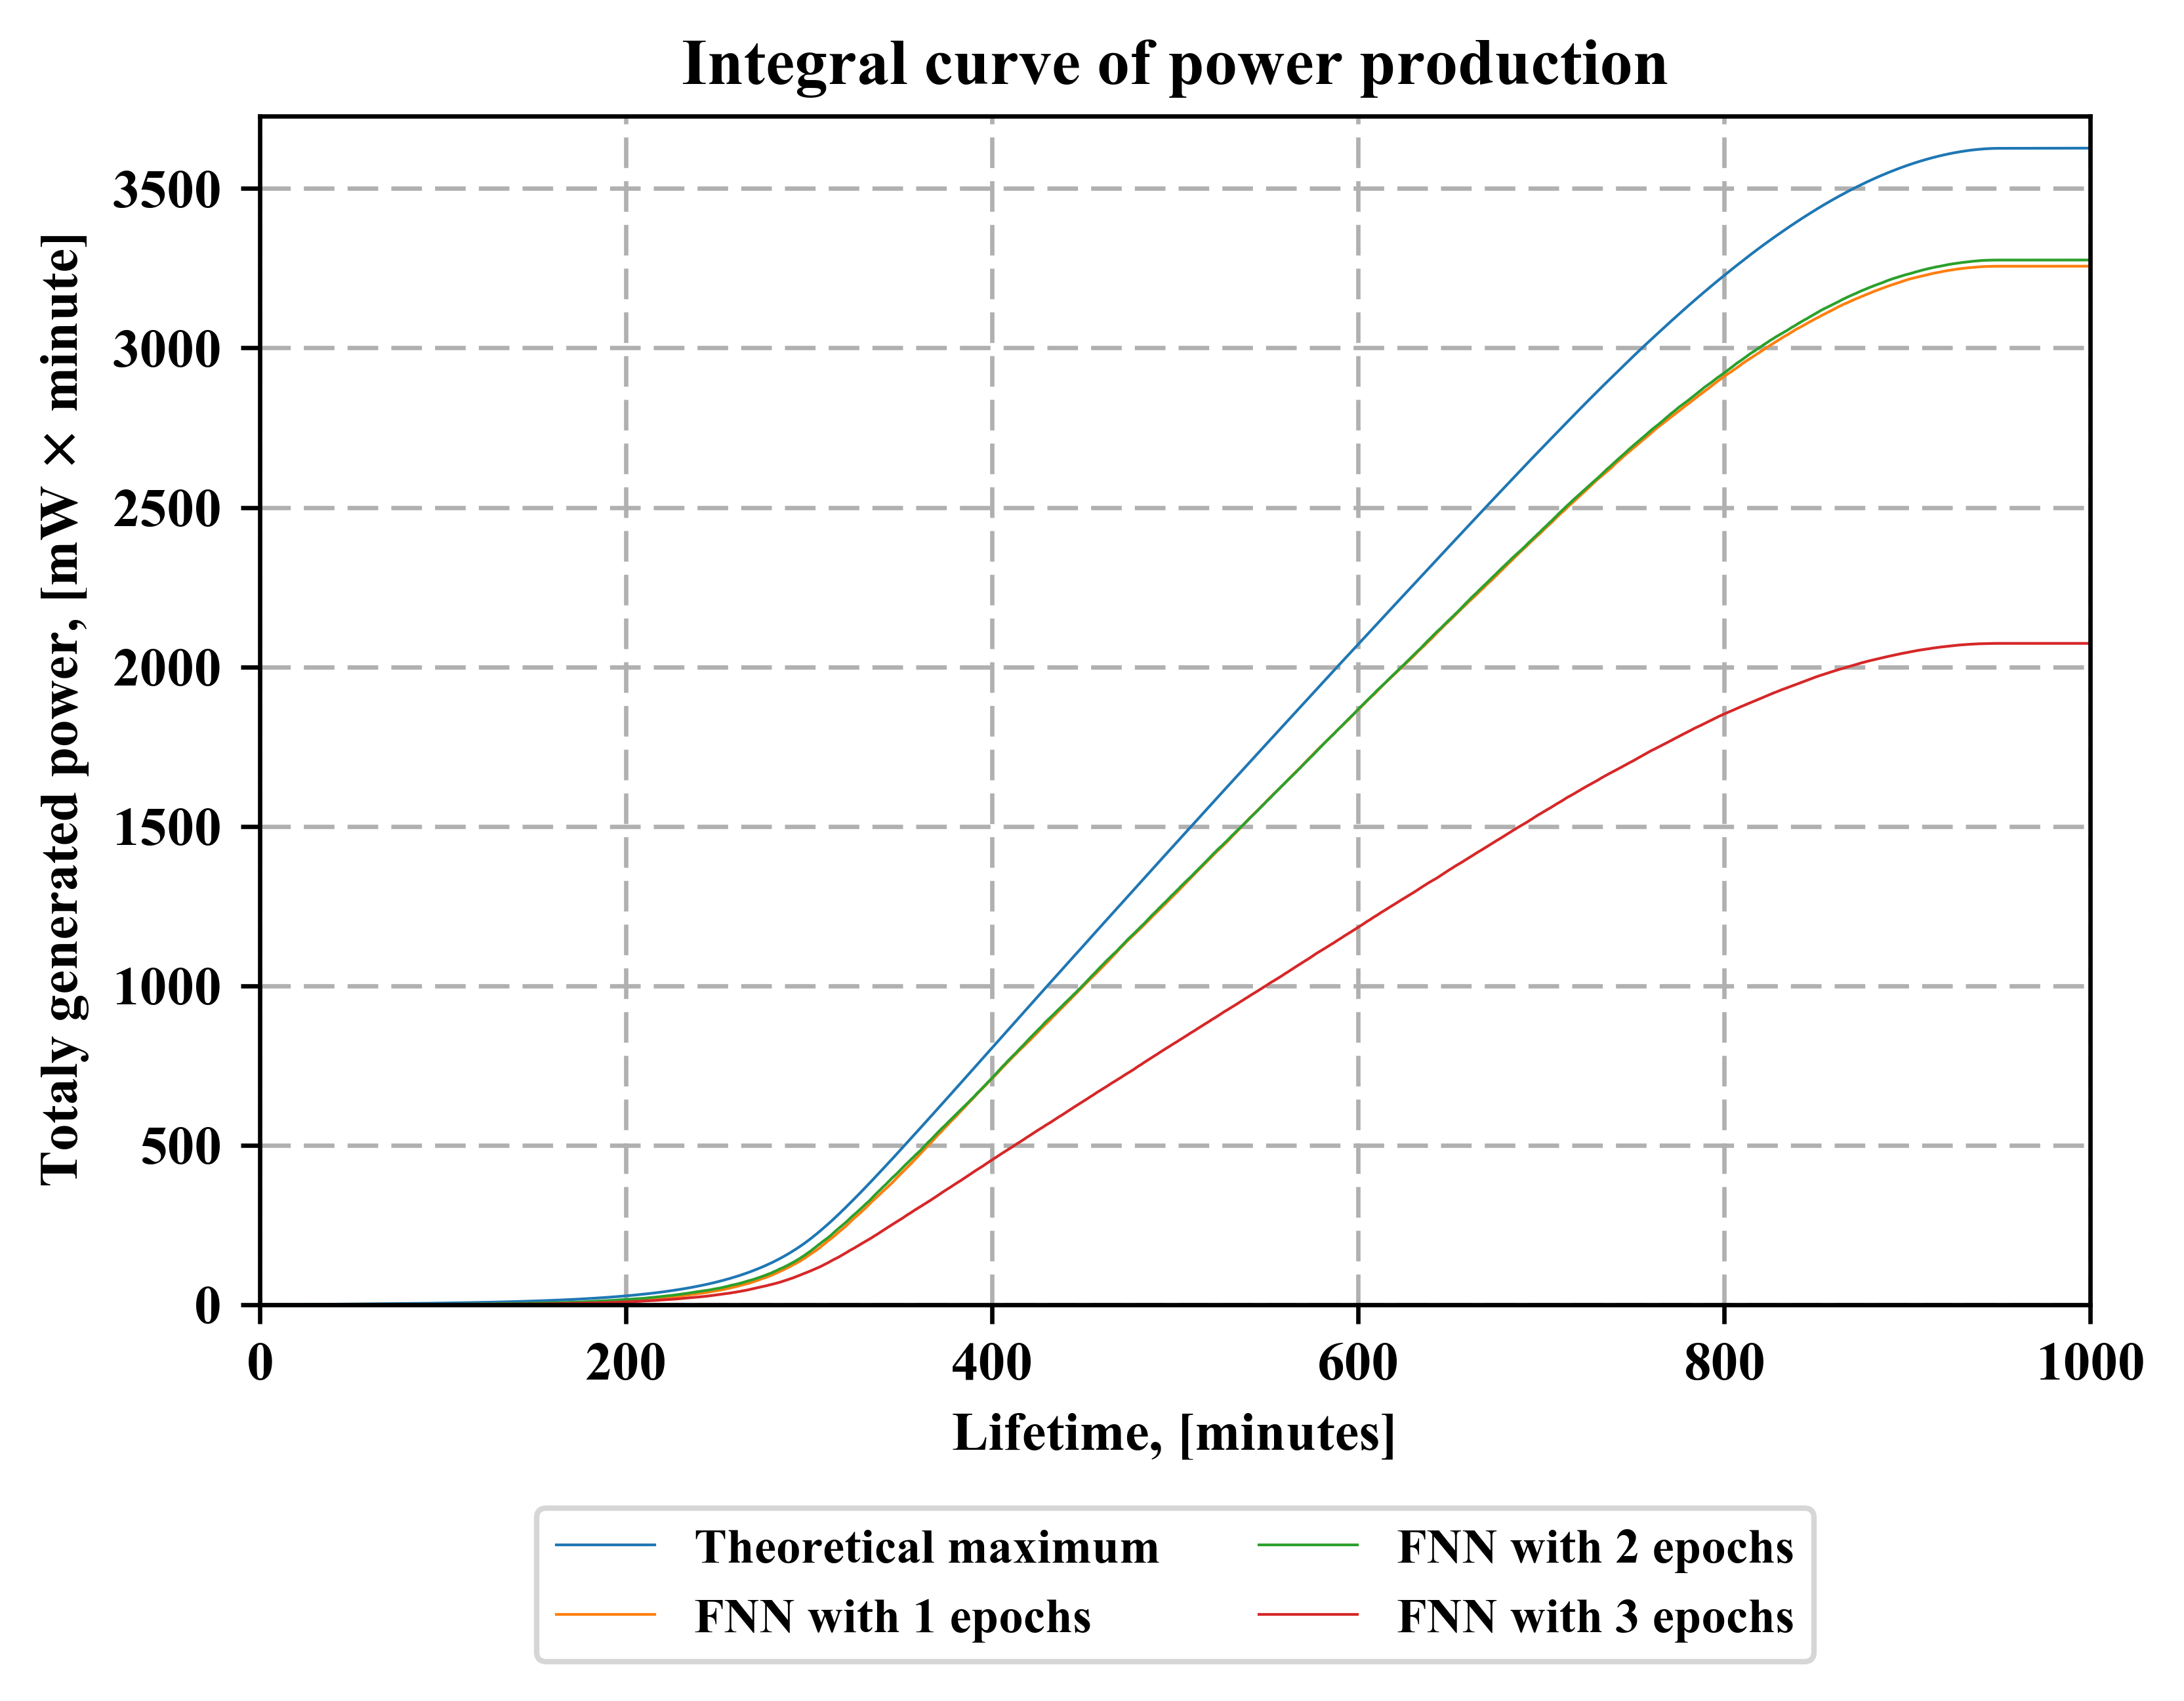

Theoretical maximum 	:  3626.249 mWt
	Loses 	: 0.0 %
FNN with 1 epochs 	:  3256.222 mWt
	Loses 	: 10.2 %
FNN with 2 epochs 	:  3275.567 mWt
	Loses 	: 9.67 %
FNN with 3 epochs 	:  2073.843 mWt
	Loses 	: 42.81 %


In [ ]:
plot_power_differential (dataset_2)
plot_power_integral (dataset_2)

for data in dataset_2:    
    print (data.label, "\t: ", round(data.total_power/1000, 3), "mWt")
    print ("\tLoses \t:", round((1 - data.total_power / dataset[0].total_power)*100, 2), "%")

In [ ]:
# Predictive NN
dataset_3 = [MPL]
PNN_1 = PNN (NN_inputs, epochs = 1)
PNN_1.fit()
PNN_1.predict_and_track()
dataset_3.append(PNN_1)

PNN_2 = PNN (NN_inputs, epochs = 2)
PNN_2.fit()
PNN_2.predict_and_track()
dataset_3.append(PNN_2)

PNN_3 = PNN (NN_inputs, epochs = 3)
PNN_3.fit()
PNN_3.predict_and_track()
dataset_3.append(PNN_3)

Epoch 1/1
200000/200000 [==============================] - 9s - loss: 233.0170 - acc: 0.0366     
Epoch 1/2


In [ ]:
plot_power_differential (dataset_3)
plot_power_integral (dataset_3)

for data in dataset_3:    
    print (data.label, "\t: ", round(data.total_power/1000, 3), "mWt")
    print ("\tLoses \t:", round((1 - data.total_power / dataset[0].total_power)*100, 2), "%")